In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import random
from collections import OrderedDict
from scripts.smallNNRegression import NetRegr

# Cold Posteriors

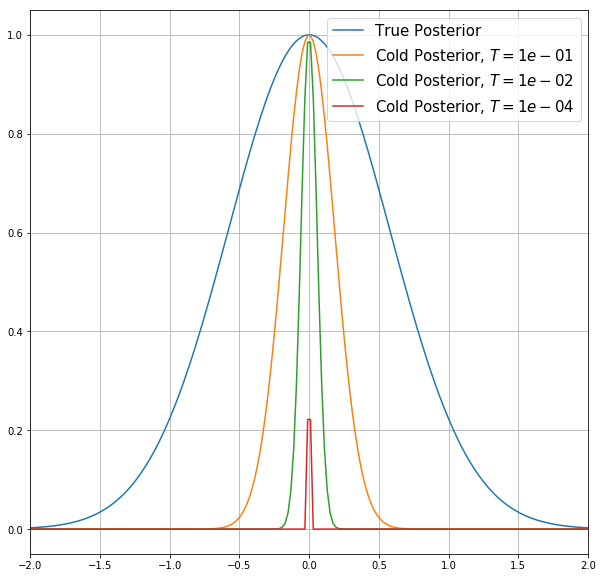

In [2]:
%matplotlib inline
x = np.linspace(-5,5,500)
y = np.array([np.exp(-xi**2)*np.exp(-0.5*xi**2) for xi in x])
plt.figure(figsize=(10,10))
plt.plot(x, y, label=r'True Posterior')
plt.plot(x, y**10, label=r'Cold Posterior, $T={:.0e}$'.format(0.1))
plt.plot(x, y**100, label='Cold Posterior, $T={:.0e}$'.format(0.01))
plt.plot(x, y**1e4, label='Cold Posterior, $T={:.0e}$'.format(0.0001))
plt.grid()
plt.xlim(-2,2)
plt.legend(fontsize = 15, loc ='upper right')
plt.savefig("imgs/ColdPosteriorUnimodal.png")
plt.show()

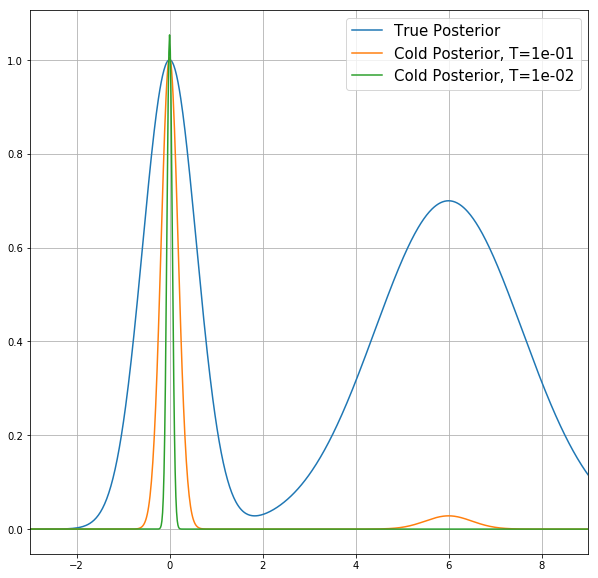

In [3]:
%matplotlib inline
x = np.linspace(-5,10,1000)
y = np.array([np.exp(-xi**2)*np.exp(-0.5*xi**2) + 0.7*np.exp(-0.2*(xi-6)**2) for xi in x])

plt.figure(figsize=(10,10))
plt.plot(x, y, label=r'True Posterior')
plt.plot(x, y**10, label='Cold Posterior, T={:.0e}'.format(0.1))
plt.plot(x, y**100, label='Cold Posterior, T={:.0e}'.format(0.01))
plt.grid()
plt.xlim(-3,9)
plt.legend(fontsize = 15, loc='upper right')
plt.savefig("imgs/ColdPosteriorBimodal.png")
plt.show()

# Tempered Posterior

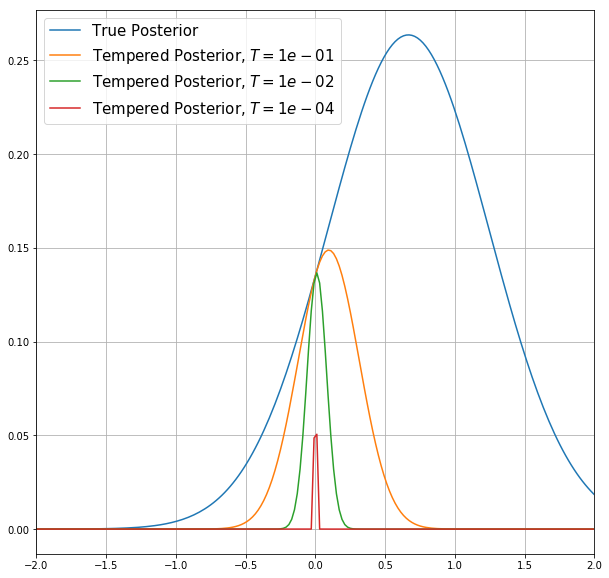

In [4]:
%matplotlib inline
x = np.linspace(-5,5,500)
likelihood = np.array([np.exp(-xi**2) for xi in x])
prior = np.array([np.exp(-0.5*(xi-2)**2) for xi in x])
plt.figure(figsize=(10,10))
plt.plot(x, [y_l * y_p for y_l, y_p in zip(likelihood, prior)], label=r'True Posterior')
for temperature in [10, 100, 1e4]:
    plt.plot(x, np.exp(temperature*np.log(likelihood))*prior, label=r'Tempered Posterior, $T={:.0e}$'.format(1/temperature))
plt.grid()
plt.xlim(-2,2)
plt.legend(fontsize = 15, loc ='upper left')
plt.savefig("imgs/TemperedPosteriorUnimodal.png")
plt.show()

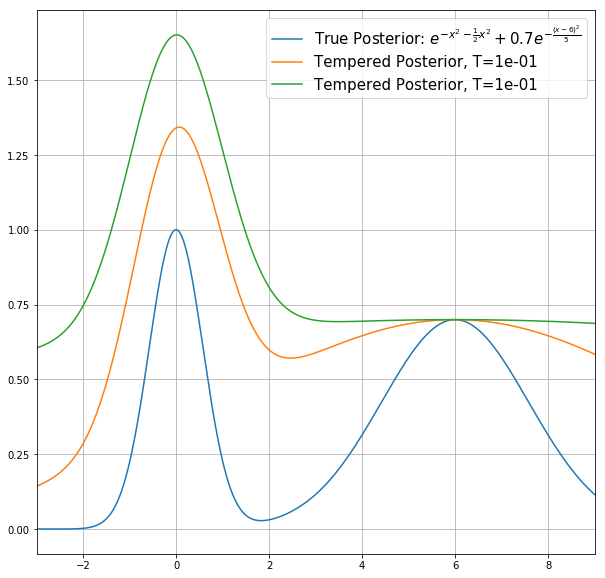

In [24]:
%matplotlib inline
x = np.linspace(-5,10,1000)
full_posterior = np.array([np.exp(-xi**2)*np.exp(-0.5*xi**2) + 0.7*np.exp(-0.2*(xi-6)**2) for xi in x])
likelihood_a = np.array([np.exp(-xi**2) for xi in x])
prior_a = np.array([np.exp(-0.5*xi**2) for xi in x])
likelihood_b = np.array([np.exp(-0.2*(xi-6)**2) for xi in x]).flatten()

plt.figure(figsize=(10,10))
plt.plot(x, full_posterior, label=r'True Posterior: $e^{-x^2-\frac{1}{2}x^2} + 0.7e^{-\frac{(x-6)^2}{5}} $')
for temperature in [0.1, 0.01]:
    plt.plot(x, np.exp(temperature*np.log(likelihood_a))*prior_a + 0.7*np.exp(temperature*np.log(likelihood_b)),label='Tempered Posterior, T={:.0e}'.format(0.1))
plt.grid()
plt.xlim(-3,9)
plt.legend(fontsize = 15, loc='upper right')
plt.savefig("imgs/TemperedPosteriorBimodal.png")
plt.show()

## Cold vs. Tempered Posterior

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


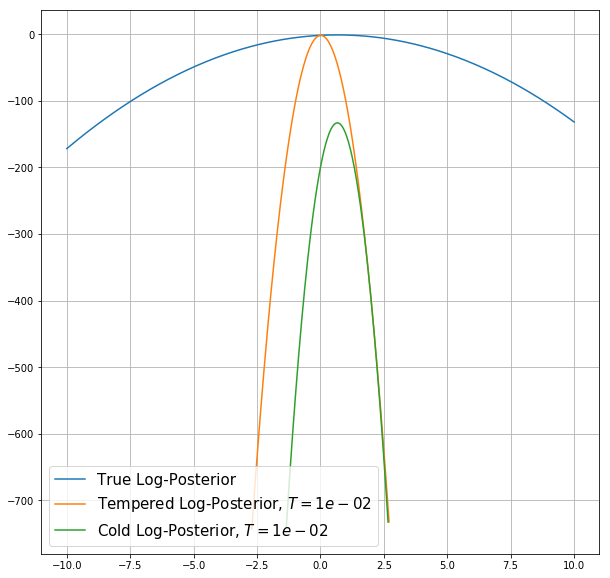

In [5]:
%matplotlib inline
x = np.linspace(-10,10,500)
likelihood = np.array([np.exp(-xi**2) for xi in x])
prior = np.array([np.exp(-0.5*(xi-2)**2) for xi in x])
plt.figure(figsize=(10,10))
temperature = 100
plt.plot(x, np.log(likelihood*prior), label=r'True Log-Posterior')
plt.plot(x, np.log(np.exp(temperature*np.log(likelihood))*prior), label=r'Tempered Log-Posterior, $T={:.0e}$'.format(1/temperature))
plt.plot(x, np.log((likelihood*prior)**temperature), label=r'Cold Log-Posterior, $T={:.0e}$'.format(1/temperature))
plt.grid()
plt.legend(fontsize = 15, loc ='lower left')
plt.savefig("imgs/ComparisonLogPosteriors.png")
plt.show()

## Temperature and Learning Rate

In [1]:
data = np.loadtxt('example_data.txt', delimiter=',')
X = data[:,0]
y = data[:,1]

X = np.reshape(X,(X.shape[0],1))
y = np.reshape(y, (y.shape[0],1))

X, y = torch.from_numpy(X).type(torch.FloatTensor), torch.from_numpy(y).type(torch.FloatTensor)

N = X.shape[0] 
M = 280
a, b = np.floor(min(X)), np.ceil(max(X))    
Xtest = torch.from_numpy(np.linspace(a-2, b+2, M).reshape(-1,1)).type(torch.FloatTensor)

In [2]:
def negative_log_prior(params):
    regularization_term = 0
    for name, W in params:
        regularization_term += W.norm(2)
    return 0.5*regularization_term

In [3]:
loss_fn = torch.nn.MSELoss(reduction='sum')
epochs = 100
lrs = [0.01,0.02,0.05,0.1, 0.5]
Ts = [10, 5, 2, 1, 0.2]

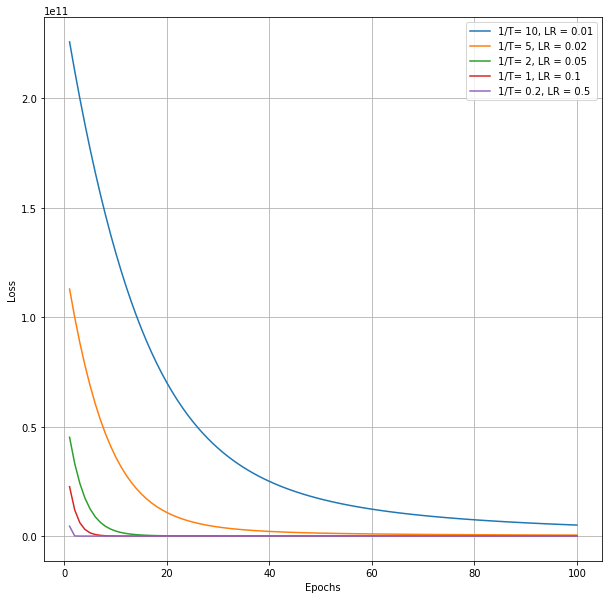

In [5]:
plt.figure(figsize=(10,10))
for lr, T in zip(lrs, Ts):
    net = NetRegr()
    state_dict={}
    for name, param in net.named_parameters():
        state_dict[name] = torch.ones(param.size())
    state_dict_it = OrderedDict(state_dict)
    net.load_state_dict(state_dict_it, strict=False)
    loss_history = []
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for i in range(epochs):
        optimizer.zero_grad()

        pred = net(X)
        loss = T*(loss_fn(pred, y)+negative_log_prior(net.named_parameters()))

        loss_history.append(loss)
        loss.backward()
        optimizer.step()
    
    plt.plot(range(1,epochs+1),loss_history, label="1/T= {}, LR = {}".format(T, lr))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Noise on the Images

In [40]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


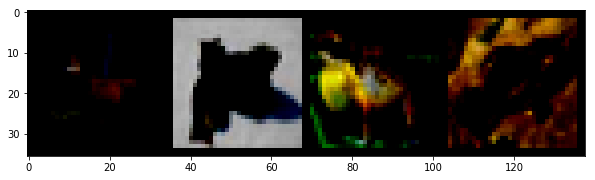

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


           deer            frog            frog            frog


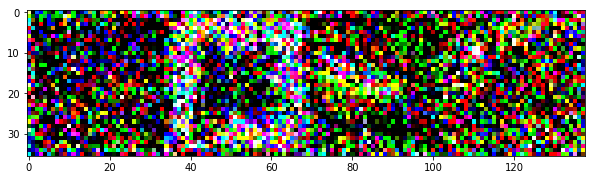

In [56]:
def imshow(img, curated = True):
    plt.figure(figsize=(10,10))
    if not curated:
        img += torch.randn(img.size())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images), curated = True)
# print labels
print(' '.join('%15s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images), curated = False)

# Cold Posterior on Curated Datasets

In [3]:
results_cold = pd.read_csv('results/CIFAR10ColdCurated',names=['nsamples','keep_every','burn_in','learning_rate','temperature','accuracy'],header=None)
results_cold['max'] = results_cold.groupby(['nsamples','keep_every','burn_in','learning_rate'])['accuracy'].transform('max')
results_cold = results_cold.sort_values(['max','nsamples','keep_every','burn_in','learning_rate','temperature','accuracy'], ascending=True).drop('max', axis=1)
results_cold = results_cold.reset_index(drop=True)

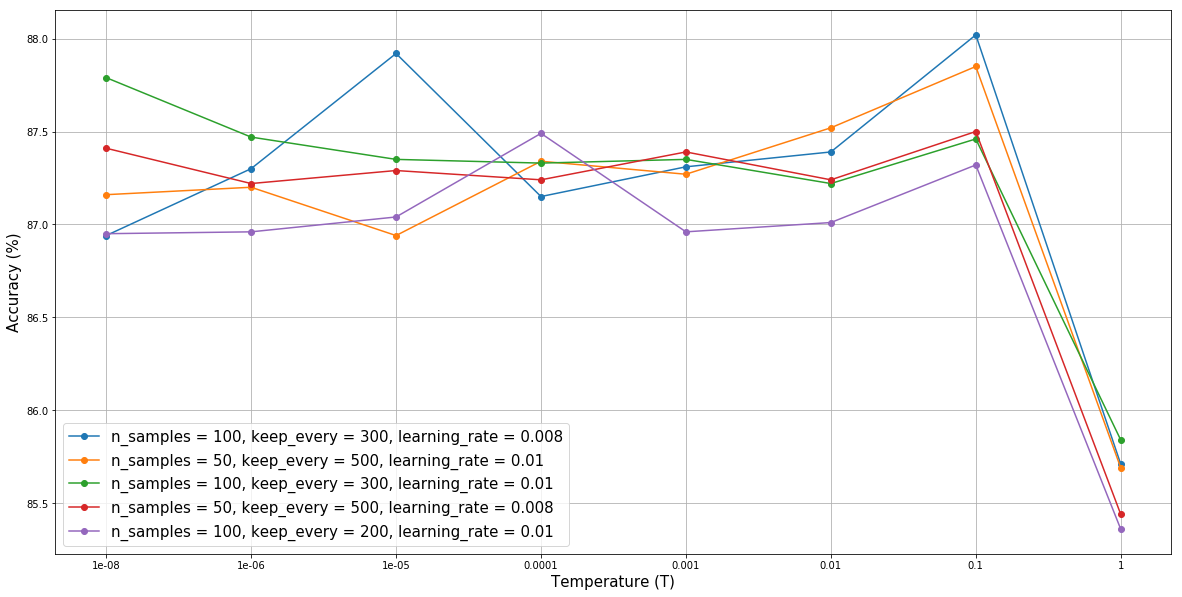

In [4]:
%matplotlib inline
plt.figure(figsize = (20,10))
for i in range(8,41,8):
    plt.plot(range(8),results_cold.loc[len(results_cold)-i:len(results_cold)-i+7,'accuracy'],marker="o", 
                label="n_samples = {}, keep_every = {}, learning_rate = {}".\
             format(results_cold.at[len(results_cold)-i,'nsamples'],results_cold.at[len(results_cold)-i,'keep_every'],results_cold.at[len(results_cold)-i,'learning_rate']))
plt.xticks(range(8),[1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
plt.xlabel("Temperature (T)",fontsize = 15)
plt.ylabel("Accuracy (%)",fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.savefig("imgs/ColdPosteriorCurated.png")
plt.show()

In [5]:
results_cold['max_delta'] = results_cold.groupby(['nsamples','keep_every','burn_in','learning_rate'])['accuracy'].transform('max') - results_cold.groupby(['nsamples','keep_every','burn_in','learning_rate'])['accuracy'].transform('min')
results_cold = results_cold.sort_values(['max_delta','nsamples','keep_every','burn_in','learning_rate','temperature','accuracy'], ascending=True).drop('max_delta', axis=1)
results_cold = results_cold.reset_index(drop=True)

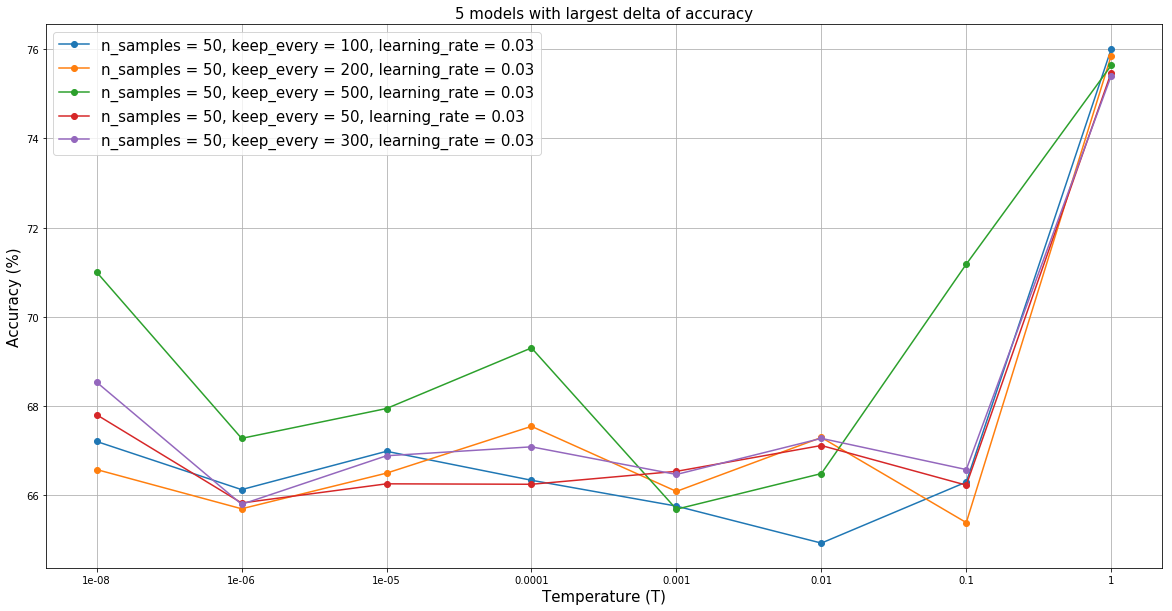

In [6]:
%matplotlib inline
plt.figure(figsize = (20,10))
for i in range(8,41,8):
    plt.plot(range(8),results_cold.loc[len(results_cold)-i:len(results_cold)-i+7,'accuracy'],marker="o", 
                label="n_samples = {}, keep_every = {}, learning_rate = {}".\
             format(results_cold.at[len(results_cold)-i,'nsamples'],results_cold.at[len(results_cold)-i,'keep_every'],results_cold.at[len(results_cold)-i,'learning_rate']))
plt.xticks(range(8),[1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
plt.xlabel("Temperature (T)",fontsize = 15)
plt.ylabel("Accuracy (%)",fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.title("5 models with largest delta of accuracy", fontsize = 15)
plt.show()

# Effects of Cold Posterior on Non-Curated Datasets (Noise on the Labels)

In [8]:
noncurated_cold = pd.read_csv('results/CIFAR10ColdNonCurated',names=['nsamples','keep_every','burn_in','learning_rate','temperature','accuracy','uncertainty'],header=None)

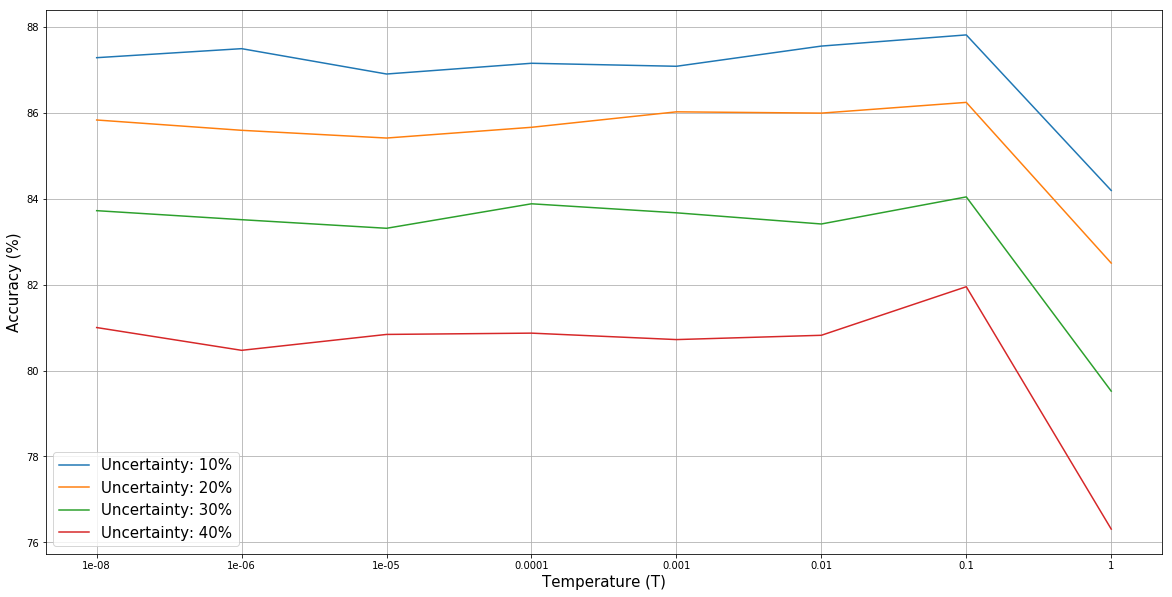

In [9]:
%matplotlib inline
plt.figure(figsize = (20,10))
for i in range(8,len(noncurated_cold)+1,8):
    plt.plot(range(8),noncurated_cold.loc[i-8:i-1,'accuracy'], label="Uncertainty: {}%".format(int(noncurated_cold.at[i-8,'uncertainty']*100)))
plt.xticks(range(8),[1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
plt.xlabel("Temperature (T)",fontsize = 15)
plt.ylabel("Accuracy (%)",fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.savefig("imgs/ColdPosteriorNonCuratedLabels.png")
plt.show()

# Effects of Cold Posterior on Non-Curated Datasets (Noise on the Images)

In [25]:
noncurated_cold = pd.read_csv('results/CIFAR10ColdNonCuratedImages',names=['nsamples','keep_every','burn_in','learning_rate','temperature','accuracy','uncertainty'],header=None)

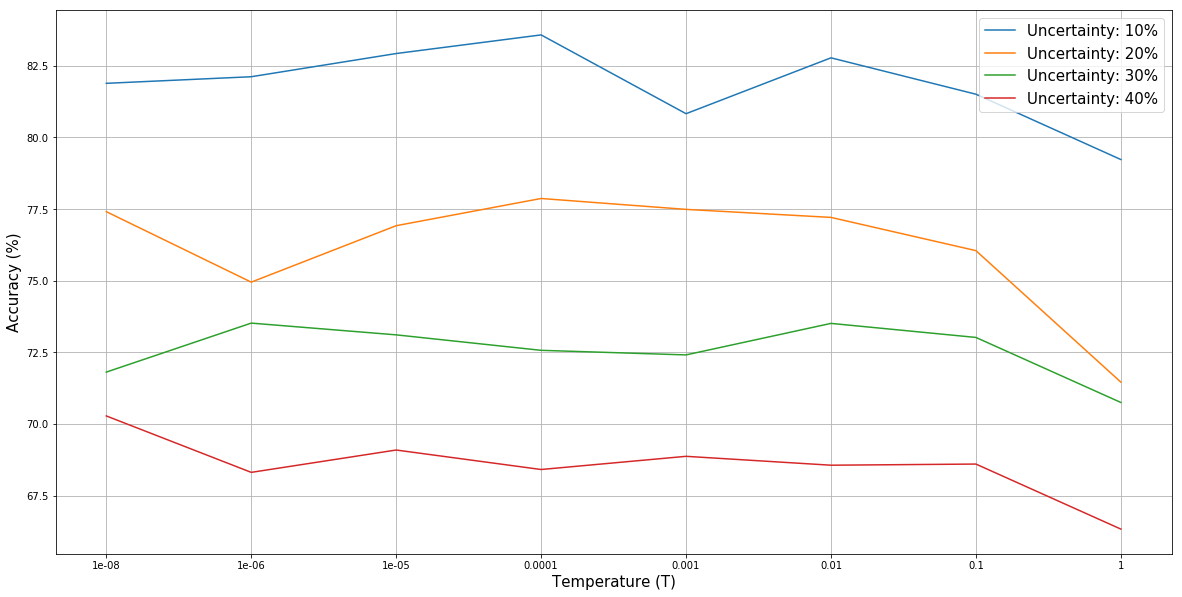

In [27]:
%matplotlib inline
plt.figure(figsize = (20,10))
for i in range(8,len(noncurated_cold)+1,8):
    plt.plot(range(8),noncurated_cold.loc[i-8:i-1,'accuracy'], label="Uncertainty: {}%".format(int(noncurated_cold.at[i-8,'uncertainty']*100)))
plt.xticks(range(8),[1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
plt.xlabel("Temperature (T)",fontsize = 15)
plt.ylabel("Accuracy (%)",fontsize = 15)
plt.legend(fontsize = 15,loc='upper right')
plt.grid()
plt.savefig("imgs/ColdPosteriorNonCuratedImages.png")
plt.show()

# Effects of Tempered Posterior on Curated Datasets

In [12]:
tempered = pd.read_csv('results/CIFAR10TemperedCurated',names=['nsamples','keep_every','burn_in','learning_rate','temperature','accuracy'],header=None)

In [13]:
tempered['max'] = tempered.groupby(['nsamples','keep_every','burn_in','learning_rate'])['accuracy'].transform('max')
tempered['min'] = tempered.groupby(['nsamples','keep_every','burn_in','learning_rate'])['accuracy'].transform('min')
tempered['delta'] = tempered['max']-tempered['min']
tempered = tempered.drop(['max','min'],axis=1)
tempered = tempered.sort_values(['delta','nsamples','keep_every','burn_in','learning_rate','temperature','accuracy'], ascending=True).drop('delta', axis=1)
tempered = tempered.reset_index(drop=True)

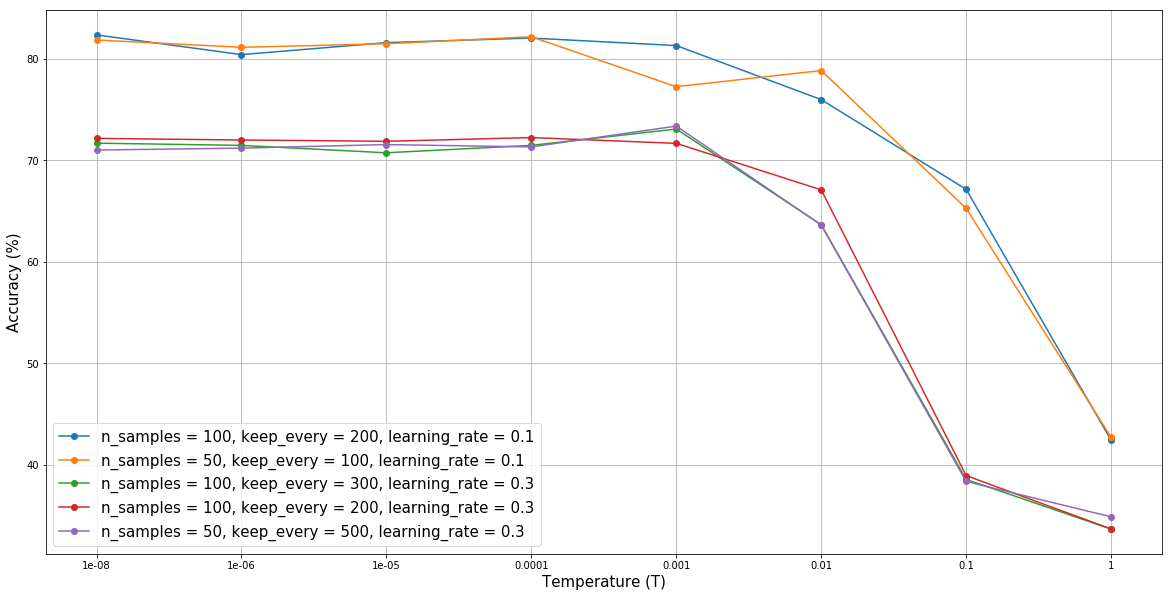

In [14]:
%matplotlib inline
plt.figure(figsize = (20,10))
for i in range(8,41,8):
    plt.plot(range(8),tempered.loc[len(tempered)-i:len(tempered)-i+7,'accuracy'],marker="o", 
                label="n_samples = {}, keep_every = {}, learning_rate = {}".\
             format(tempered.at[len(tempered)-i,'nsamples'],tempered.at[len(tempered)-i,'keep_every'],tempered.at[len(tempered)-i,'learning_rate']))
plt.xticks(range(8),[1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
plt.xlabel("Temperature (T)",fontsize = 15)
plt.ylabel("Accuracy (%)",fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.savefig("imgs/TemperedPosteriorCurated1.png")
plt.show()

In [15]:
tempered = tempered[tempered['learning_rate']<=0.03]
tempered['max'] = tempered.groupby(['nsamples','keep_every','burn_in','learning_rate'])['accuracy'].transform('max')
tempered = tempered.sort_values(['max','nsamples','keep_every','burn_in','learning_rate','temperature','accuracy'], ascending=True).drop('max', axis=1)
tempered = tempered.reset_index(drop=True)

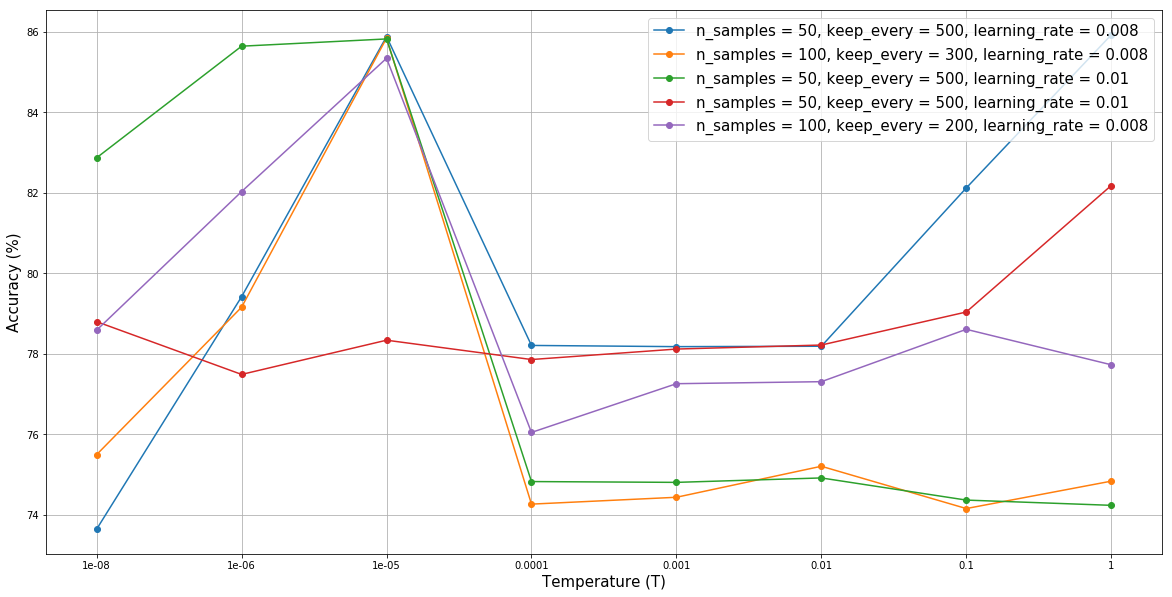

In [16]:
%matplotlib inline
plt.figure(figsize = (20,10))
for i in range(8,41,8):
    plt.plot(range(8),tempered.loc[len(tempered)-i:len(tempered)-i+7,'accuracy'],marker="o", 
                label="n_samples = {}, keep_every = {}, learning_rate = {}".\
             format(tempered.at[len(tempered)-i,'nsamples'],tempered.at[len(tempered)-i,'keep_every'],tempered.at[len(tempered)-i,'learning_rate']))
plt.xticks(range(8),[1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
plt.xlabel("Temperature (T)",fontsize = 15)
plt.ylabel("Accuracy (%)",fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.savefig("imgs/TemperedPosteriorCurated2.png")
plt.show()

# Effects of Tempered Posterior on Non-Curated Datasets (Noise on the Labels)

In [17]:
noncurated_tempered = pd.read_csv('results/CIFAR10TemperedNonCurated',names=['nsamples','keep_every','burn_in','learning_rate','temperature','accuracy','uncertainty'],header=None)

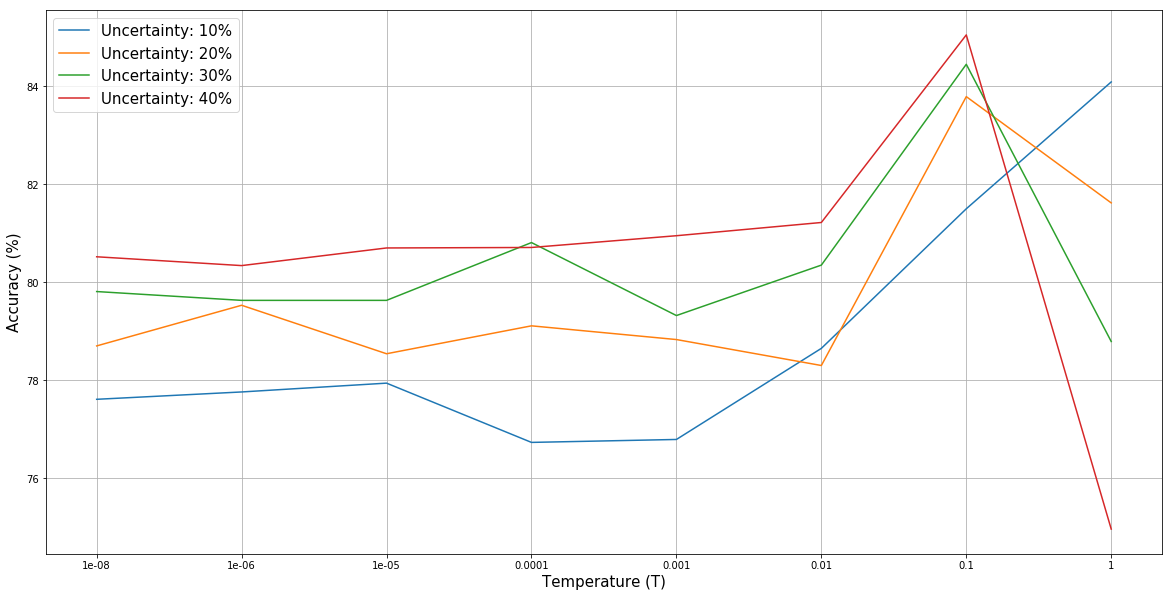

In [18]:
%matplotlib inline
plt.figure(figsize = (20,10))
for i in range(8,len(noncurated_tempered)+1,8):
    plt.plot(range(8),noncurated_tempered.loc[i-8:i-1,'accuracy'], label="Uncertainty: {}%".format(int(noncurated_tempered.at[i-8,'uncertainty']*100)))
plt.xticks(range(8),[1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
plt.xlabel("Temperature (T)",fontsize = 15)
plt.ylabel("Accuracy (%)",fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.savefig("imgs/TemperedPosteriorNonCuratedLabels.png")
plt.show()

# Effects of Tempered Posterior on Non-Curated Datasets (Noise on the Images)

In [19]:
noncurated_tempered = pd.read_csv('results/CIFAR10TemperedNonCuratedImages',names=['nsamples','keep_every','burn_in','learning_rate','temperature','accuracy','uncertainty'],header=None)

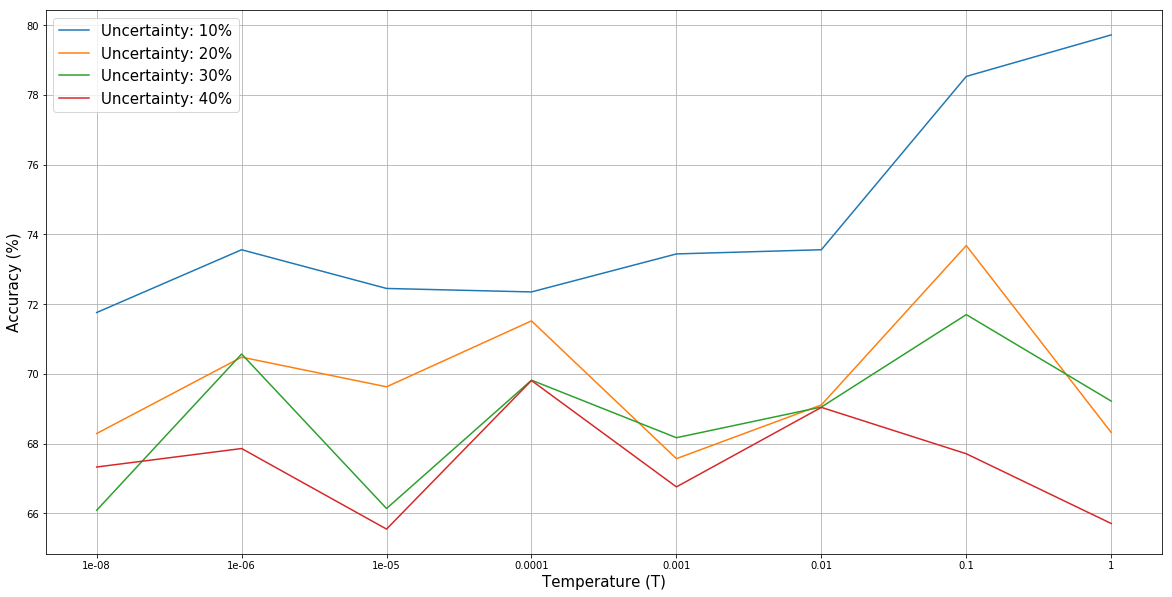

In [20]:
%matplotlib inline
plt.figure(figsize = (20,10))
for i in range(8,len(noncurated_tempered)+1,8):
    plt.plot(range(8),noncurated_tempered.loc[i-8:i-1,'accuracy'], label="Uncertainty: {}%".format(int(noncurated_tempered.at[i-8,'uncertainty']*100)))
plt.xticks(range(8),[1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
plt.xlabel("Temperature (T)",fontsize = 15)
plt.ylabel("Accuracy (%)",fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.savefig("imgs/TemperedPosteriorNonCuratedImages.png")
plt.show()

# Online News Popularity - UCI Dataset

# Effects of Cold Posterior

In [30]:
onp_cold = pd.read_csv("results/ONP.txt",header=0)
onp_cold = onp_cold[onp_cold['SCALING'] == 'cold']
onp_cold = onp_cold.reset_index(drop=True)

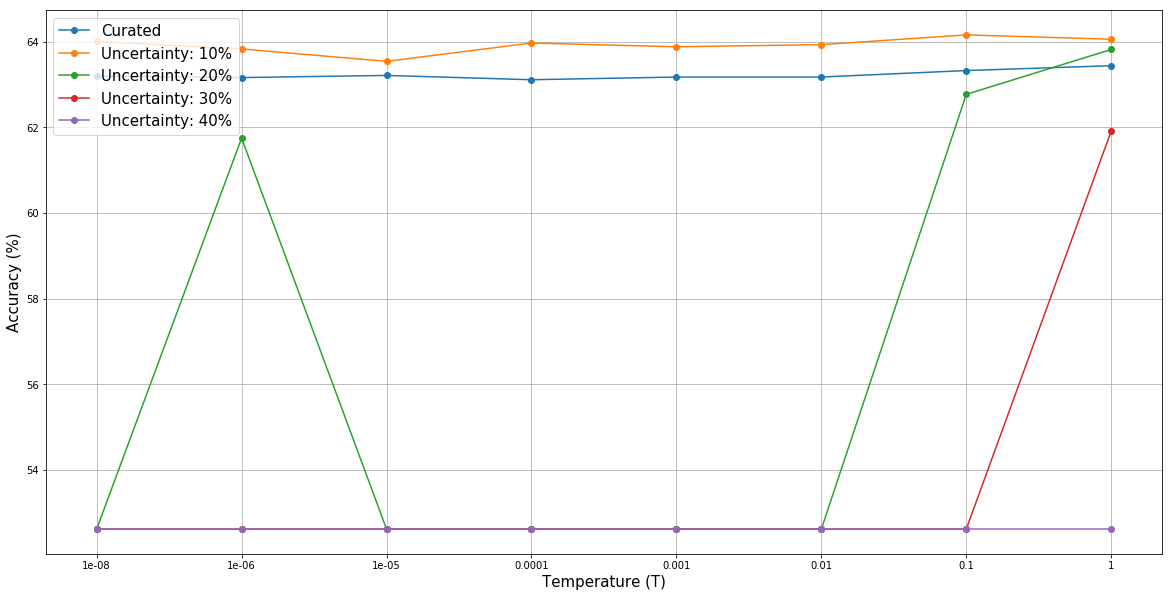

In [31]:
%matplotlib inline
plt.figure(figsize=(20,10))
for i in range(8,len(onp_cold)+1,8):
    if onp_cold.at[i-8,'UNCERTAINTY'] == 0:
        plt.plot(range(8),onp_cold.loc[i-8:i-1,'ACCURACY'], label = 'Curated',marker='o')
    else:
         plt.plot(range(8),onp_cold.loc[i-8:i-1,'ACCURACY'], label="Uncertainty: {}%".format(int(onp_cold.at[i-8,'UNCERTAINTY']*100)),marker='o')
plt.xticks(range(8),[1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
plt.xlabel("Temperature (T)",fontsize = 15)
plt.ylabel("Accuracy (%)",fontsize = 15)
plt.legend(fontsize = 15, loc='upper left')
plt.grid()
#plt.savefig("imgs/ONPCold.png")
plt.show()   

# Effects of Tempered Posterior

In [23]:
onp_tempered = pd.read_csv("results/ONP.txt",header=0)
onp_tempered = onp_tempered[onp_tempered['SCALING'] == 'tempered']
onp_tempered = onp_tempered.reset_index(drop=True)

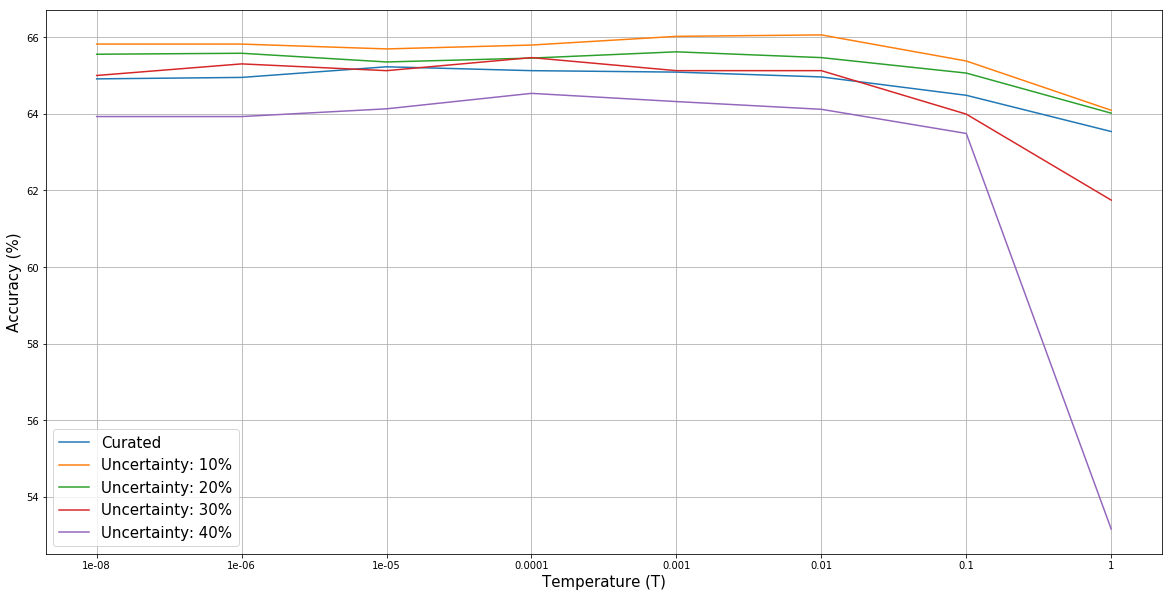

In [24]:
%matplotlib inline
plt.figure(figsize=(20,10))
for i in range(8,len(onp_tempered)+1,8):
    if onp_cold.at[i-8,'UNCERTAINTY'] == 0:
        plt.plot(range(8),onp_tempered.loc[i-8:i-1,'ACCURACY'], label = 'Curated')
    else:
         plt.plot(range(8),onp_tempered.loc[i-8:i-1,'ACCURACY'], label="Uncertainty: {}%".format(int(onp_tempered.at[i-8,'UNCERTAINTY']*100)))
plt.xticks(range(8),[1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
plt.xlabel("Temperature (T)",fontsize = 15)
plt.ylabel("Accuracy (%)",fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.savefig("imgs/ONPTempered.png")
plt.show()   